In [48]:
## Parameters specific to where your folders are and your data
parameter_file = 'params/params.yaml'
import yaml
import sys

with open(parameter_file,'r') as f:
    doc = yaml.load(f)

#p = dic2obj(**doc)

data_folder = doc['data_folder']
tissues = doc['tissues'].split(',')
sys.path.append(doc['pipeline_path'])
ref_fa = doc['ref_fa']
anno_gff=doc['annotation']
supplemental = doc['supplemental']
tss_annotation = doc['tss_annotation']

import os
os.chdir
import sys
import pandas as pd
import matplotlib
import seaborn as sns
import pickle
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
from itertools import product
import glob
import re
from matplotlib_venn import venn2
from matplotlib import rcParams
import inspect
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
sys.setrecursionlimit(3000)
%load_ext autoreload
%autoreload 2
rcParams['figure.figsize'] = 8, 6
import tqdm

from os.path import basename
##mpl.use('Agg')
#mpl.style.use('ggplot')
#mpl.style.use('fivethirtyeight')
from Homer import *

print('Number of tissues: ',len(tissues))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
('Number of tissues: ', 15)


In [2]:
sys.path.append("/home/isshamie/software/homebrew/parallel_functions/")
import parallel_functions as pf

In [3]:
import motif_analysis

In [4]:
motif_folder = doc['motif_folder']
motifs_of_interest = map(lambda x: os.path.basename(x).split('.')[0],glob.glob(motif_folder + '/*motif'))
motifs_of_interest

['scl',
 'cdx2',
 'fli',
 'pu1',
 'elf3',
 'klf10',
 'sp5',
 'oct2',
 'ebna1',
 'phox2a',
 'hinfp',
 'bcl6',
 'smad4',
 'pknox1',
 'gata3',
 'myf5',
 'staf',
 'pbx2',
 'tbet',
 'znf528',
 'pax7-longest',
 'spdef',
 'tra',
 'klf14',
 'nrf',
 'p53-myc',
 'gata3',
 'sp2',
 'foxa1',
 'hif2a',
 'vdr',
 'znf264',
 'gabp',
 'tead',
 'irf1',
 'sf1',
 'znf136',
 'p65',
 'klf6',
 'stat6',
 'tcf7l2',
 'zscan22',
 'six4',
 'gfi1b',
 'foxl2',
 'tr4',
 'gata3',
 'mef2d',
 'grhl2',
 'ptf1a',
 'znf322',
 'lxre',
 'ar-half',
 'npas',
 'fosl2',
 'arnt',
 'gata3',
 'lhx2',
 'nfat-ap1',
 'ets-runx',
 'erg',
 'meis1',
 'tbx20',
 'znf675',
 'hoxd12',
 'nfatc1',
 'rfx2',
 'znf415',
 'hnf1b',
 'e2f6',
 'usf2',
 'foxo3',
 'pit1-long',
 'ews-fli1',
 'oct',
 'ehf',
 'are-fox',
 'pax3-fkhr',
 'jun-cre',
 'sox3',
 'limb',
 'runx1m',
 'tfe3',
 'stat1',
 'couptf2',
 'heb',
 'zfp809',
 'nfy',
 'gata2',
 'p53',
 'zfp281',
 'brn2',
 'jun-ap1',
 'elf1',
 'rxr',
 'atf7',
 'zic3',
 'foxa2',
 'pax5',
 'pax7-long',
 'znf416

In [5]:
curr = pickle.load(open("Results/old_results_1_2_2019/motifs/allPeaks_instance_inr_instance.p","rb"))

In [7]:
peaks_df = pd.read_csv("Results/merged/peaks_with_tss_distances.tsv",sep="\t",index_col=0)
peaks_df["Length"] = peaks_df["End"] - peaks_df["Start"]
peaks_df.index = peaks_df.index.astype(str)

peaks_df["inr"] = np.nan
peaks_df.head()



,Chr,Start,End,Strand,Stat,Annotation,Nearest TSS,Distance to TSS,isSameStrand,Nearest gene,Nearest gene_id,Length,inr
ID,,,,,,,,,,,,,
0,picr_9,30423275,30423564,+,10.506897,"exon (asmbl_83977, exon 1 of 1)",asmbl_83977,4098.0,False,SALL1,gene_29627,289,NaN
1,picr_27,14937806,14938107,-,22.268621,promoter-TSS (asmbl_40109),asmbl_40105,-159.0,False,RBM25,gene_13991_3,301,NaN
2,picr_2,5127066,5127335,+,1.732333,"intron (asmbl_29716, intron 9 of 9)",asmbl_29719,-8640.0,True,FAM83C,gene_10160,269,NaN
3,picr_15,26110487,26110670,+,1.659667,"intron (asmbl_22566, intron 1 of 4)",asmbl_22566,24071.0,True,ZNRF1,gene_7657_3,183,NaN
4,picr_0,73670402,73670628,+,1.694250,Intergenic,asmbl_3271,-74096.0,True,MAN2A1,gene_975,226,NaN


## Initialize a motif dataframe, which is a region-by-length boolean matrix with a 1 in regions the motif was found. The index is the region name (peaks)

In [58]:
def initialize_motif_df(inds, seq_len=151):
    motif_df = pd.DataFrame(
        index=inds,
        columns=np.arange(0 - int(seq_len / 2),
                          np.ceil(seq_len / 2)).astype(int),
        dtype=bool)
    motif_df[:] = False
    return motif_df


def fill_motif_df(motifs,
                  motif_df_pos,
                  motif_df_neg,
                  len_dict,
                  motif_len,
                  seq_len=151):
    assert (((motif_df_pos == 0).all().all()) &
            ((motif_df_neg == 0).all().all()))
    for key in tqdm.tqdm(motifs):
        if len(motifs[key]) > 0:
            #print(motifs[key])
            for loc in motifs[key][0]:
                ## Center the location, which is diferent if pos or neg strand:
                if loc >= 0:
                    pos = int(loc - np.floor(1.0 * len_dict[key] / 2))
                    if pos in motif_df_pos.columns:
                        motif_df_pos.at[key, pos] = True
                else:
                    pos = int(
                        loc + np.ceil(1.0 * len_dict[key] / 2) - 1 +
                        motif_len)  #Still need to know the length of the motif
                    if pos in motif_df_neg.columns:
                        motif_df_neg.at[key, pos] = True
    return motif_df_pos, motif_df_neg


def wrap_one_motif_df(motif_locs, peaks, motif_len, seq_len=151):
    motif_pos = initialize_motif_df(peaks.index, seq_len=151)
    motif_neg = initialize_motif_df(peaks.index, seq_len=151)

    motif_pos, motif_neg = fill_motif_df(motif_locs, motif_pos, motif_neg,
                                         peaks["Length"].to_dict(), motif_len,
                                         seq_len)
    return [motif_pos, motif_neg]


def wrap_motifs(motif_list, names_list, peaks, pfm_path):
    for ind, i in enumerate(motif_list):
        curr = pickle.load(open(i, "rb"))
        motif_len = pd.read_csv(
            os.path.join(pfm_path, names_list[ind] + ".motif.pfm"),
            header=None,
            sep="\t").shape[1]

        binary_mat = wrap_one_motif_df(curr, peaks, motif_len, seq_len=151)
        plot_count(binary_mat, names_list[ind])
        pickle.dump(binary_mat, open(i.strip(".p") + "_binary.p", "wb"))


def plot_count(motifs_mat, name):
    f, ax = plt.subplots()
    motifs_mat[0].sum().plot()
    (-1 * motifs_mat[1].sum()).plot()
    plt.title(name)

In [10]:
foo = {k: curr[k] for k in list(map(lambda x: str(x), np.arange(0,1000)))}

In [51]:
pfm_list = glob.glob(os.path.join(supplemental, "homer_motifs/*.pfm"))

In [56]:
pfm_list[0]

'/data/isshamie/TSS/Analysis/supplemental/homer_motifs/pbx3.motif.pfm'

In [55]:
pd.read_csv(pfm_list[0],header=None,sep="\t").shape[1]

12

100%|██████████| 484058/484058 [00:08<00:00, 55911.93it/s]


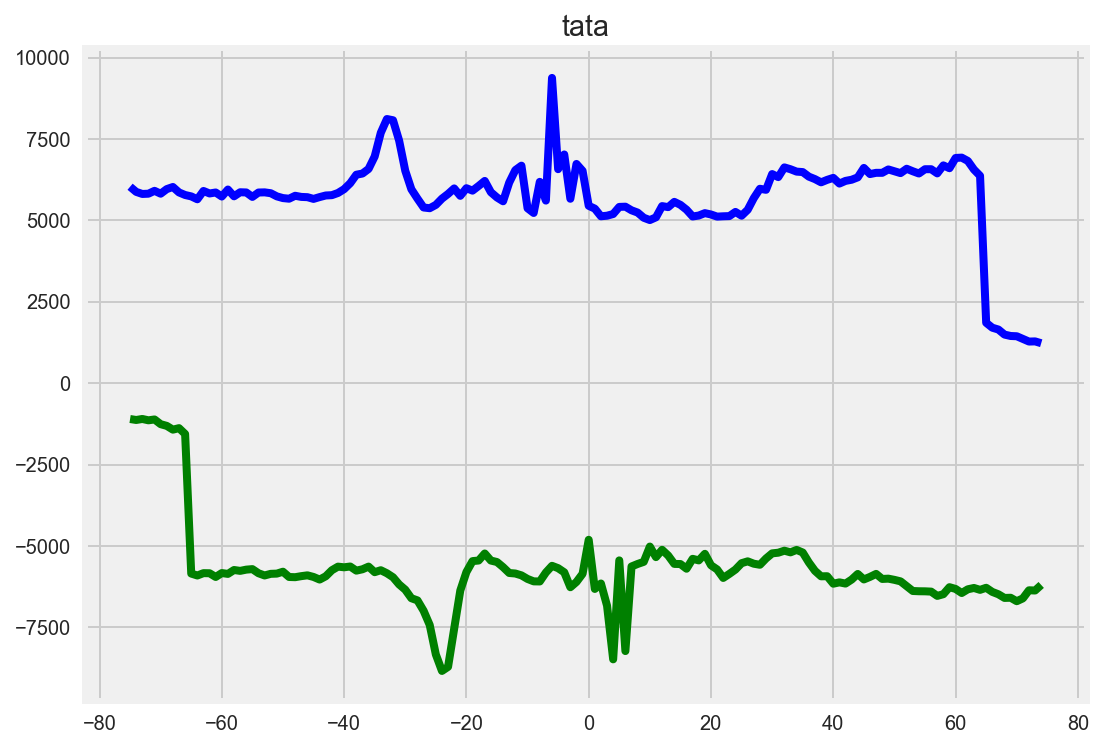

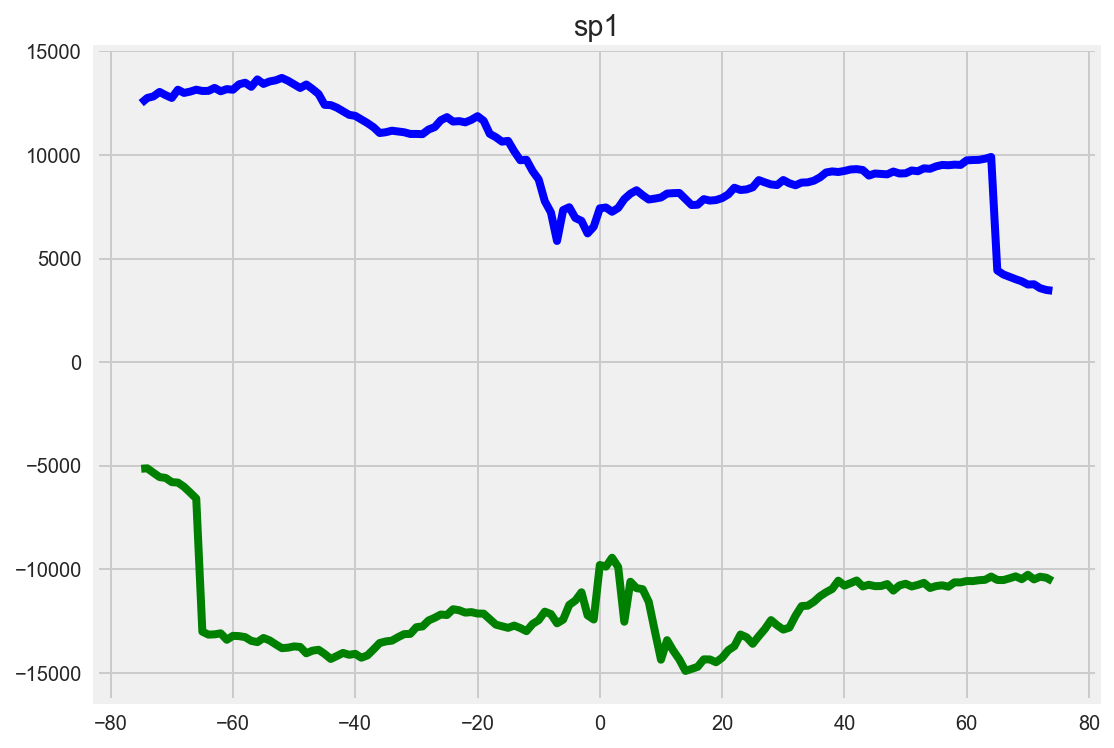

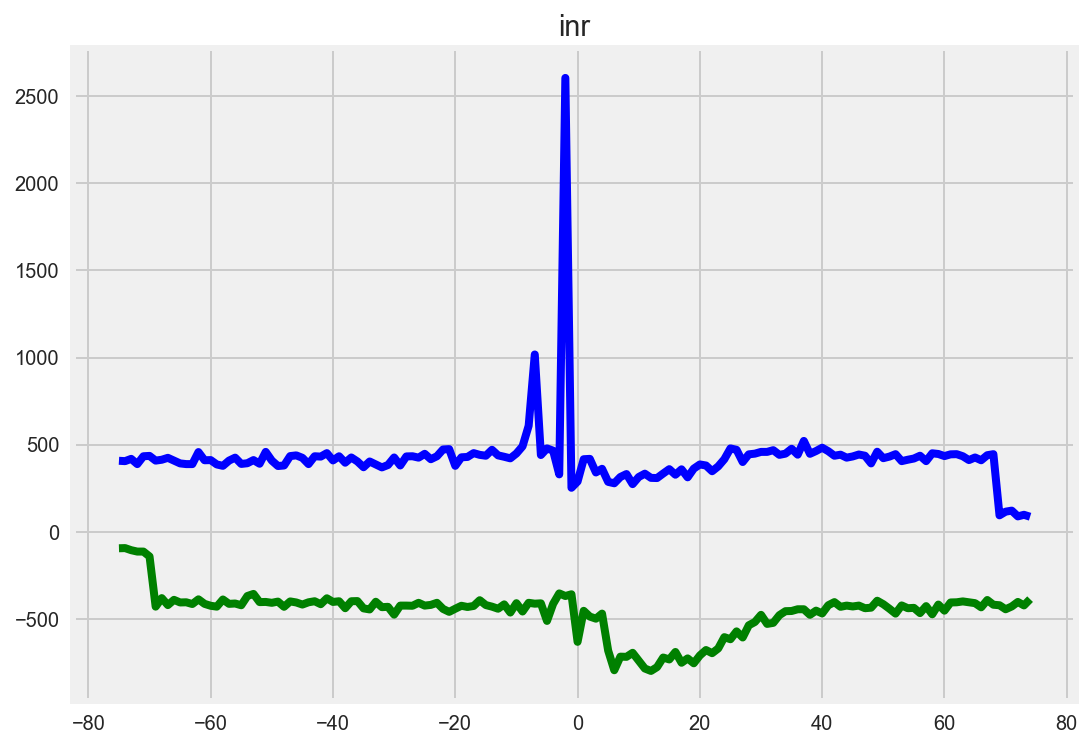

In [61]:
motifs_list = glob.glob("Results/old_results_1_2_2019/motifs/allPeaks*instance.p")
#pfm_list = glob.glob(os.path.join(supp_f, "homer_motifs/*.pfm"))
pfm_path = os.path.join(supplemental, "homer_motifs")
names_list = list(map(lambda x: x.split("instance")[1].replace("_",""), motifs_list))
wrap_motifs(motifs_list,names_list,peaks_df,pfm_path)

In [108]:
names_list

['nonbininr']

In [110]:
motifs_list

['Results/Figures/SuppFigure3/TSS1.exp_refseq_center_instance_nonbin_inr_instance.p']

In [115]:
curr = pickle.load(open(motifs_list[0],"rb"))
curr

{'p2@DDAH1_gene_29685_2_asmbl_84163': [],
 'p2@CACNA1A_gene_7947_asmbl_23579': [],
 'p2@PATZ1_gene_2192_1_asmbl_6626': [],
 'p2@LPCAT3_gene_4011_asmbl_11701': [],
 'p1@PHC3_gene_18227_asmbl_51446': [],
 'p1@PBRM1_gene_9461_1_asmbl_27563': [],
 'p2@PLXNB1_gene_23293_asmbl_66047': [],
 'p1@PBRM1_gene_9461_1_asmbl_27566': [],
 'p2@FN3KRP_gene_21505_asmbl_60315': [],
 'p2@PLXNB1_gene_23293_asmbl_66049': [],
 'p1@ILF2_gene_24132_asmbl_68425': [],
 'p1@SLC6A13_gene_20207_asmbl_56770': [],
 'p1@ILF2_gene_24132_asmbl_68423': [],
 'p1@BMPER_gene_8105_asmbl_24079': [],
 'p1@RGN_gene_9933_asmbl_28956': [],
 'p1@DCAF15_gene_7931_asmbl_23542': [],
 'p1@DCAF15_gene_7931_asmbl_23543': [],
 'p1@NEIL2_gene_12772_asmbl_36604': [],
 'p1@NEK9_gene_14032_asmbl_40283': [],
 'p1@NEK9_gene_14032_asmbl_40284': [],
 'p1@RBM7_gene_8466_asmbl_25003': [],
 'p2@SLC25A28_gene_13194_asmbl_38060': [],
 'p3@ADAMTS19_gene_19995_asmbl_56034': [],
 'p2@PGAM5_gene_29175_asmbl_82742': [],
 'p1@MLXIPL_gene_30553_1_asmbl_8646

100%|██████████| 35247/35247 [00:00<00:00, 816718.32it/s]


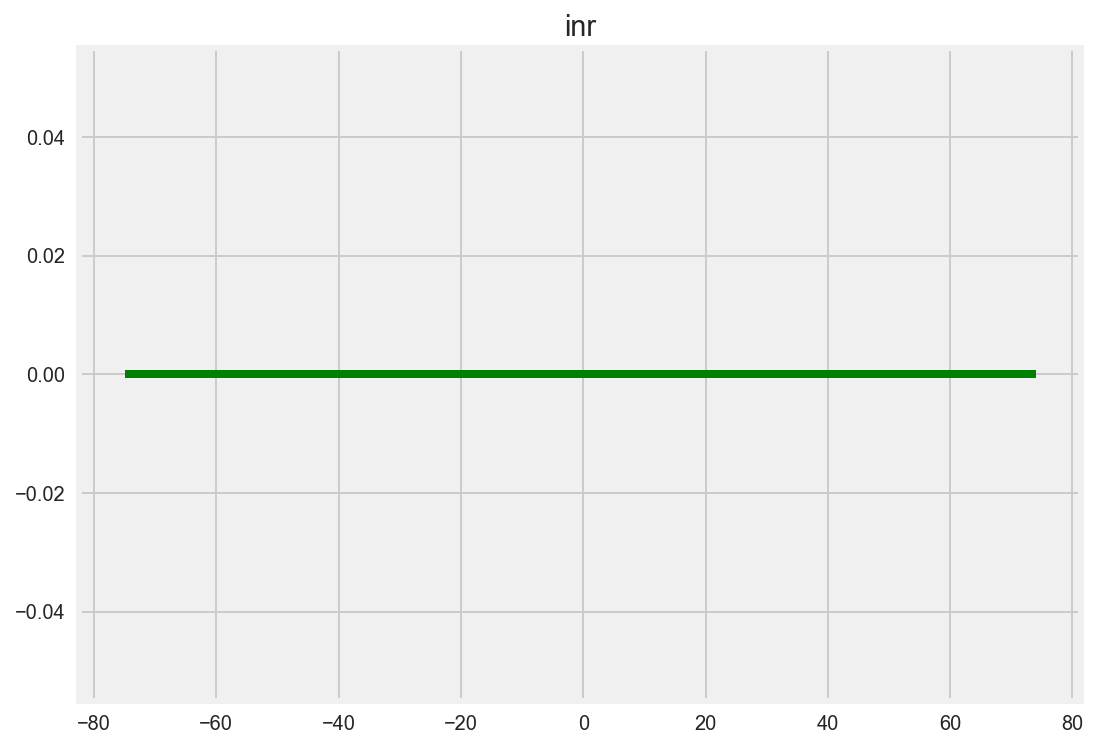

In [113]:
motifs_list = glob.glob('Results/Figures/SuppFigure3/TSS1.exp_refseq_center_instance_nonbin*instance.p')
pfm_path = os.path.join(supplemental, "homer_motifs")
names_list = ["inr"]
wrap_motifs(motifs_list,names_list,peaks_df,pfm_path)

In [62]:
curr = pickle.load(open(motifs_list[0],"rb"))
curr


{'378466': [(24, 33, 79, -61, -29, 124),
  (3.0130332, 3.7139323, 3.914305, 3.3317666, 3.7554538, 3.3324571)],
 '287145': [(-22,), (3.0740917,)],
 '378464': [(133, -18), (3.7262709, 4.1949754)],
 '378465': [(-65, 106), (3.6187754, 3.2790265)],
 '378462': [(29, -68, -39), (3.2006142, 3.1484134, 3.6751056)],
 '378463': [(-150, 2, -134, 40, -89, -80, 84, 93),
  (3.4708955,
   3.341629,
   3.3109138,
   3.3014739,
   4.2594852,
   3.3467531,
   3.5991762,
   3.3235891)],
 '378460': [(-88, 64), (4.3633208, 3.7234662)],
 '378467': [(-106,), (3.6160157,)],
 '287148': [(0, 131), (5.9118648, 3.4029577)],
 '287146': [(-21, 131, -20, 132),
  (3.6460035, 4.4550405, 3.3224657, 3.5034041)],
 '378468': [(45, -20), (3.3805478, 3.6501443)],
 '378469': [(-64, -48, -16, -14, 138),
  (4.4214702, 3.4096003, 3.2378321, 3.6367195, 4.5404296)],
 '370255': [(-107, 63, -58, -57, 95),
  (3.631748, 3.5338511, 4.1706924, 5.0506353, 3.9735622)],
 '370254': [(-142, 23, -96, -67, -22, -21, 131),
  (3.3411014,
   3.18

In [64]:
zero_instances = 0
for i in curr:
    if len(curr[i]) == 0:
        zero_instances += 1
        
print(zero_instances)
print(1.0*zero_instances/len(curr))

40488

In [69]:
from Bio import SeqIO

In [71]:
myList[0]

['264099', 'CATTGTCCCTCTGTCTA', 17]

In [73]:
seq_record

SeqRecord(seq=Seq('GATGATGGGCGGGGCCTAGAGATGGTGCTTGTGGGGGCGGAACTGGGATAGGAC...CCT', SingleLetterAlphabet()), id='55675', name='55675', description='55675', dbxrefs=[])

In [76]:
len(seq_record) > 0

True

In [79]:
max_record = 0
for seq_record in SeqIO.parse('Results/merged/samples.merge.anno.fa', "fasta"):
    if len(seq_record) > max_record:
        max_record = len(seq_record)
    
max_record

1095

In [82]:
seq_record.id

'192140'

100%|██████████| 484058/484058 [00:04<00:00, 100173.63it/s]


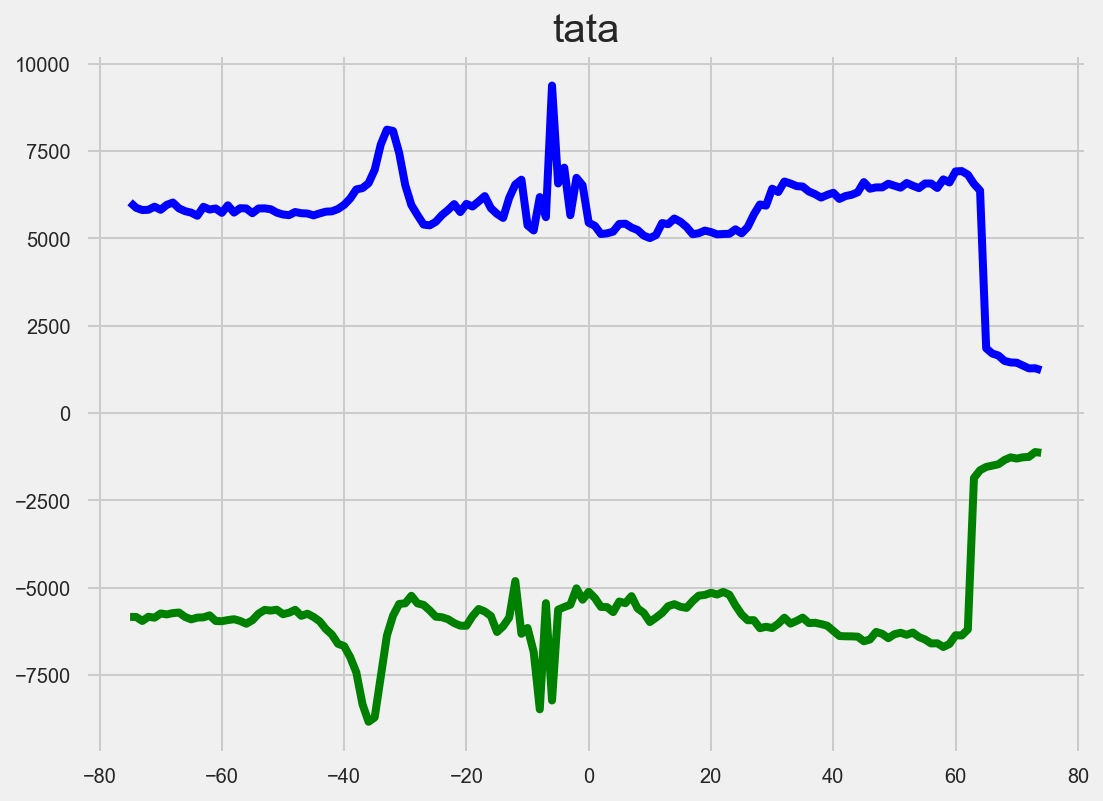

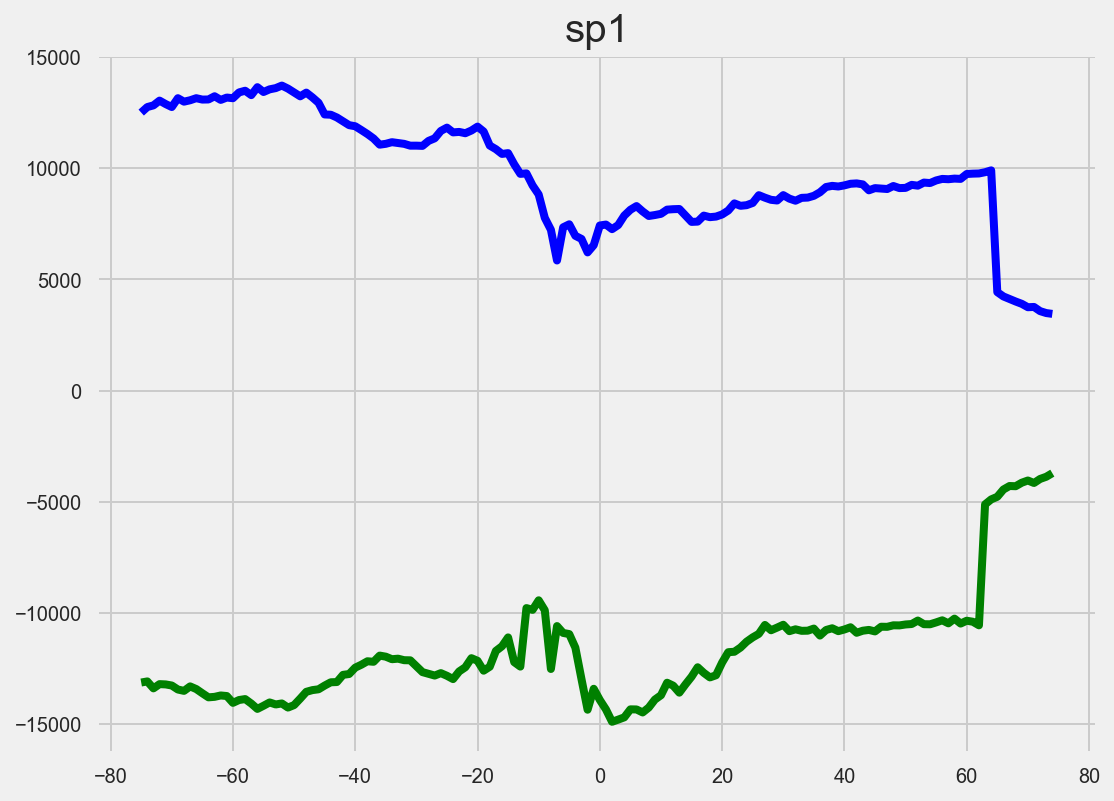

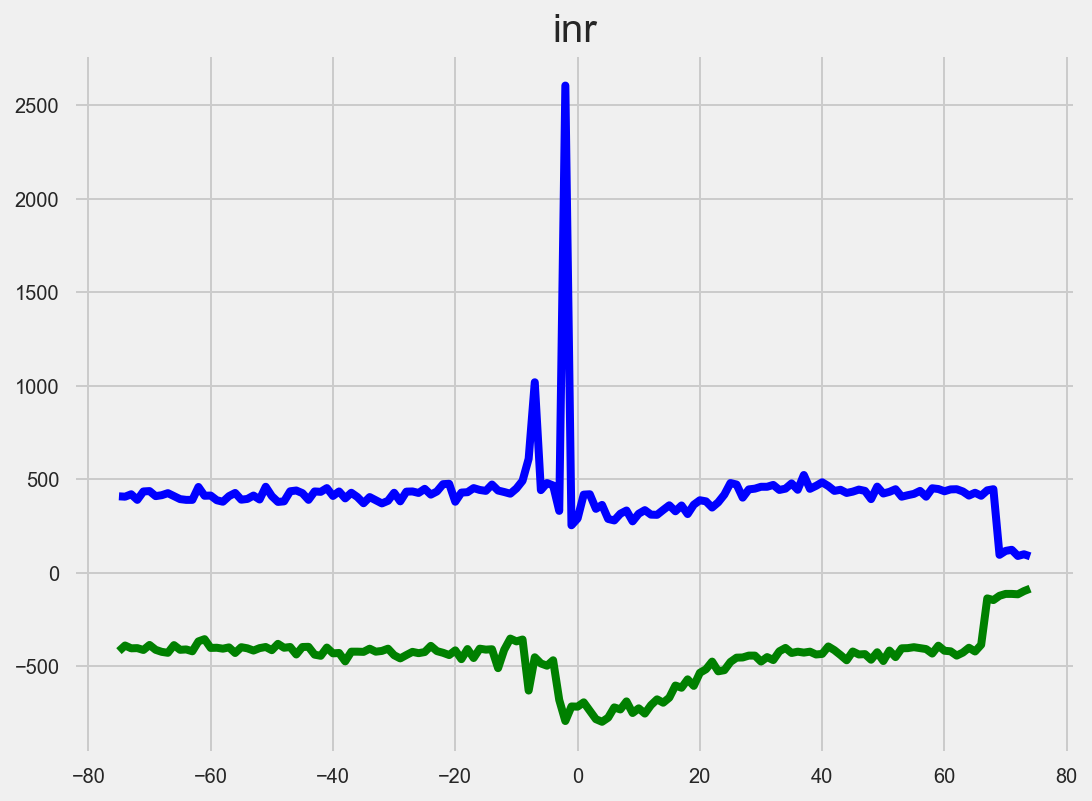

In [47]:
motifs_list = glob.glob("Results/old_results_1_2_2019/motifs/allPeaks*instance.p")
#pfm_list = glob.glob(os.path.join(supp_f, "homer_motifs/*.pfm"))
pfm_path = os.path.join(supp_f, "homer_motifs")
names_list = list(map(lambda x: x.split("instance")[1].replace("_",""), motifs_list))
wrap_motifs(motifs_list,names_list,peaks_df)

In [105]:
motifs_list = glob.glob('Results/Figures/SuppFigure3/TSS1.exp_refseq_center_instance_nonbin*instance.p')
#pfm_list = glob.glob(os.path.join(supp_f, "homer_motifs/*.pfm"))
pfm_path = os.path.join(supplemental, "homer_motifs")
names_list = list(map(lambda x: x.split("instance")[1].replace("_",""), motifs_list))
wrap_motifs(motifs_list,names_list,peaks_df)

TypeError: wrap_motifs() takes exactly 4 arguments (3 given)

------------------

------------------

In [85]:
from Bio import motifs

from Bio.Seq import Seq
instances = [
    Seq("ATTAG"),
    Seq("ATTAG"),
    Seq("ATTAG"),
    Seq("ATTAG"),
    Seq("ATTAG"),
    Seq("ATTAG"),
    Seq("ATTAG"),
]

m = motifs.create(instances)

test_seq = "ATACGCATACG"
#m = "CG"#"CGC"

pos = -2
test_seq[pos:pos+len(m)]


test_seq=Seq("ATTAGTACACTGCATTACAACCCAAGCCTAAC",m.alphabet)#ATTAG", m.alphabet)

In [86]:
test_seq[22:22+5]

Seq('CAAGC', IUPACUnambiguousDNA())

In [87]:
pwm = m.counts.normalize(pseudocounts={'A':0.6, 'C': 0.4, 'G': 0.4, 'T': 0.6})
print(pwm)

background = {'A':0.3,'C':0.2,'G':0.2,'T':0.3}
pssm = pwm.log_odds(background)
print(pssm)

for position, score in pssm.search(test_seq, threshold=3.0):
    print("Position %d: score = %5.3f" % (position, score))


        0      1      2      3      4
A:   0.84   0.07   0.07   0.84   0.07
C:   0.04   0.04   0.04   0.04   0.04
G:   0.04   0.04   0.04   0.04   0.82
T:   0.07   0.84   0.84   0.07   0.07

        0      1      2      3      4
A:   1.49  -2.17  -2.17   1.49  -2.17
C:  -2.17  -2.17  -2.17  -2.17  -2.17
G:  -2.17  -2.17  -2.17  -2.17   2.04
T:  -2.17   1.49   1.49  -2.17  -2.17

Position 0: score = 8.012
Position 13: score = 3.802
Position -5: score = 4.349


In [98]:
fa_max = 30
bar = pd.DataFrame(index=["0","1","2"],columns = np.arange(-fa_max,
                                                        fa_max),dtype=bool)
bar[:] = False
bar


,-30,-29,-28,-27,-26,-25,-24,-23,-22,-21,...,20,21,22,23,24,25,26,27,28,29
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [121]:
test_seq[-2:]

Seq('AC', IUPACUnambiguousDNA())

### Load in meta and bed files

In [ ]:
for i in glob.glob("Results/old_results_1_2_2019/motifs/allPeaks_instance*"):
    curr = pickle.load(open(i,"rb"))